SDK

In [ ]:
!pip -q install ultralytics opencv-python numpy matplotlib pandas tqdm

import os, sys
from pathlib import Path

SDK_DIR = Path("/content/robotcar-dataset-sdk")
if not SDK_DIR.exists():
    !git clone https://github.com/ori-mrg/robotcar-dataset-sdk.git /content/robotcar-dataset-sdk

SDK_PY = "/content/robotcar-dataset-sdk/python"
if SDK_PY not in sys.path:
    sys.path.insert(0, SDK_PY)

import radar
import camera_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.8 MB/s eta 0:00:00
Cloning into '/content/robotcar-dataset-sdk'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 302 (delta 44), reused 38 (delta 38), pack-reused 241 (from 1)
Receiving objects: 100% (302/302), 67.54 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (119/119), done.


구글드라이브마운트

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path

PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Project1")
ZIP_PATH    = PROJECT_DIR / "oxford_radar_robotcar_dataset_sample_large.zip"
OUT_DIR     = PROJECT_DIR / "robotcar_large_sample"

print("PROJECT_DIR:", PROJECT_DIR)
print("ZIP exists?:", ZIP_PATH.exists(), ZIP_PATH)
print("OUT_DIR:", OUT_DIR)

Mounted at /content/drive
PROJECT_DIR: /content/drive/MyDrive/Colab Notebooks/Project1
ZIP exists?: False /content/drive/MyDrive/Colab Notebooks/Project1/oxford_radar_robotcar_dataset_sample_large.zip
OUT_DIR: /content/drive/MyDrive/Colab Notebooks/Project1/robotcar_large_sample


SDK 라이브러리 다운

In [ ]:
import sys, subprocess, os
from pathlib import Path

def run(cmd):
    print(">>", " ".join(cmd))
    subprocess.run(cmd, check=True)

# 1) robotcar-dataset-sdk clone
SDK_DIR = Path("/content/robotcar-dataset-sdk")
if not SDK_DIR.exists():
    run(["git", "clone", "https://github.com/ori-mrg/robotcar-dataset-sdk.git", str(SDK_DIR)])
else:
    print("[✓] SDK already exists:", SDK_DIR)

# 2) packages
run([sys.executable, "-m", "pip", "install", "-q", "numpy", "opencv-python", "matplotlib", "pandas", "tqdm"])
run([sys.executable, "-m", "pip", "install", "-q", "ultralytics"])

[✓] SDK already exists: /content/robotcar-dataset-sdk
>> /usr/bin/python3 -m pip install -q numpy opencv-python matplotlib pandas tqdm
>> /usr/bin/python3 -m pip install -q ultralytics


데이터루트 자동탐색

In [ ]:
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Project1")

def discover_data_root(project_dir: Path) -> Path:
    candidates = []
    for p in project_dir.rglob("radar.timestamps"):
        root = p.parent
        if (root/"stereo.timestamps").exists() and (root/"stereo/left").exists():
            candidates.append(root)
    if not candidates:
        raise FileNotFoundError(f"PROJECT_DIR 아래에서 radar.timestamps를 찾지 못했습니다: {project_dir}")
    return sorted(candidates, key=lambda x: len(str(x)))[0]

DATA_ROOT = discover_data_root(PROJECT_DIR)
OUT_DIR = PROJECT_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("✅ DATA_ROOT:", DATA_ROOT)
print("✅ OUT_DIR  :", OUT_DIR)

✅ DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/Project1/robotcar_large_sample
✅ OUT_DIR  : /content/drive/MyDrive/Colab Notebooks/Project1/outputs


공통 파라미터 유틸

In [ ]:
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import math

# =========================
# params
# =========================
HOOD_Y_FRAC = 0.86

WARN_MIN, WARN_MAX = 10.0, 20.0
DANGER_MAX = 10.0

APPROACH_V_TH = 0.4
MIN_VALID_CNT = 3
MIN_APPROACH_CNT = 2

IOU_TH = 0.30
MAX_MISSED = 10

# -------------------------
# timestamp utils
# -------------------------
def load_timestamps(ts_path: Path) -> np.ndarray:
    ts = []
    with open(ts_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            ts.append(int(line.split()[0]))
    return np.array(ts, dtype=np.int64)

def nearest_ts(ts_array: np.ndarray, t: int) -> int:
    idx = np.searchsorted(ts_array, t)
    if idx <= 0: return int(ts_array[0])
    if idx >= len(ts_array): return int(ts_array[-1])
    before, after = int(ts_array[idx-1]), int(ts_array[idx])
    return before if abs(t-before) <= abs(t-after) else after

def dt_seconds(t_curr: int, t_prev: int) -> float:
    d = float(t_curr - t_prev)
    if d > 1e7:  # ns
        return max(d * 1e-9, 1e-3)
    return max(d * 1e-6, 1e-3)

# -------------------------
# geometry utils
# -------------------------
def iou_xyxy(a, b) -> float:
    ax1, ay1, ax2, ay2 = map(float, a)
    bx1, by1, bx2, by2 = map(float, b)
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2-ix1), max(0.0, iy2-iy1)
    inter = iw * ih
    area_a = max(0.0, ax2-ax1) * max(0.0, ay2-ay1)
    area_b = max(0.0, bx2-bx1) * max(0.0, by2-by1)
    union = area_a + area_b - inter + 1e-9
    return inter / union

def is_on_hood(xyxy, H: int) -> bool:
    _, _, _, y2 = map(float, xyxy)
    return y2 >= HOOD_Y_FRAC * H

# -------------------------
# Kalman Filter (CV 1D)
# state x=[d, v] , v>0 => approaching
# d_k = d_{k-1} - v_{k-1}*dt
# -------------------------
class KalmanCV1D:
    def __init__(self, d0: float, v0: float = 0.0,
                 q_d: float = 2.0, q_v: float = 4.0, r: float = 6.0):
        self.x = np.array([d0, v0], dtype=np.float32)
        self.P = np.eye(2, dtype=np.float32) * 10.0
        self.q_d = float(q_d)
        self.q_v = float(q_v)
        self.r = float(r)

    def predict(self, dt: float):
        dt = float(max(dt, 1e-3))
        F = np.array([[1.0, -dt],
                      [0.0,  1.0]], dtype=np.float32)
        Q = np.array([[self.q_d * dt * dt, 0.0],
                      [0.0, self.q_v * dt]], dtype=np.float32)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    def update(self, z: float, r: float | None = None, gate_sigma: float = 3.5):
        if z is None or (not np.isfinite(z)): return
        R = float(self.r if r is None else r)
        H = np.array([[1.0, 0.0]], dtype=np.float32)
        y = np.array([float(z)], dtype=np.float32) - (H @ self.x)
        S = float((H @ self.P @ H.T)[0, 0] + R)

        # 게이팅: 튀는 값 무시
        if abs(float(y[0])) > gate_sigma * math.sqrt(max(S, 1e-6)):
            return

        K = (self.P @ H.T) / S
        self.x = self.x + (K.flatten() * float(y[0]))
        self.P = (np.eye(2, dtype=np.float32) - K @ H) @ self.P

    @property
    def d(self) -> float:
        return float(self.x[0])

    @property
    def v(self) -> float:
        return float(self.x[1])

@dataclass
class Track:
    tid: int
    bbox: np.ndarray
    last_t: int
    kf: KalmanCV1D | None = None
    valid_cnt: int = 0
    approach_cnt: int = 0
    missed: int = 0

class IoUTracker:
    def __init__(self,
                 iou_th=0.30, max_missed=10,
                 kf_q_d=2.0, kf_q_v=4.0,
                 R_stereo=12.0, R_radar=4.0,
                 gate_sigma=3.5):
        self.iou_th = float(iou_th)
        self.max_missed = int(max_missed)
        self.kf_q_d = float(kf_q_d)
        self.kf_q_v = float(kf_q_v)
        self.R_stereo = float(R_stereo)
        self.R_radar = float(R_radar)
        self.gate_sigma = float(gate_sigma)

        self.tracks: dict[int, Track] = {}
        self.next_id = 1

    def _meas_R(self, dist_key: str) -> float:
        return self.R_stereo if dist_key == "stereo_dist_m" else self.R_radar

    def update(self, dets: list[dict], t: int, dist_key: str):
        track_ids = list(self.tracks.keys())
        unmatched_tracks = set(track_ids)
        unmatched_dets = set(range(len(dets)))
        matches = []

        ious = []
        for ti in track_ids:
            row = []
            for di in range(len(dets)):
                row.append(iou_xyxy(self.tracks[ti].bbox, dets[di]["xyxy"]))
            ious.append(row)

        # greedy
        while True:
            best_iou, best_ti, best_di = 0.0, None, None
            for ti_idx, ti in enumerate(track_ids):
                if ti not in unmatched_tracks: continue
                for di in list(unmatched_dets):
                    val = ious[ti_idx][di] if len(ious) else 0.0
                    if val > best_iou:
                        best_iou, best_ti, best_di = val, ti, di
            if best_ti is None or best_iou < self.iou_th:
                break
            matches.append((best_ti, best_di))
            unmatched_tracks.remove(best_ti)
            unmatched_dets.remove(best_di)

        # matched update
        for ti, di in matches:
            tr = self.tracks[ti]
            tr.missed = 0
            tr.bbox = np.array(dets[di]["xyxy"], dtype=np.float32)

            dist = dets[di].get(dist_key, None)
            if dist is None or (not np.isfinite(dist)) or dist <= 0:
                tr.valid_cnt = 0
                tr.approach_cnt = 0
            else:
                dt = dt_seconds(t, tr.last_t)
                if tr.kf is None:
                    tr.kf = KalmanCV1D(float(dist), 0.0, q_d=self.kf_q_d, q_v=self.kf_q_v, r=self._meas_R(dist_key))
                else:
                    tr.kf.predict(dt)
                    tr.kf.update(float(dist), r=self._meas_R(dist_key), gate_sigma=self.gate_sigma)

                tr.valid_cnt = min(tr.valid_cnt + 1, 999)
                if tr.kf.v >= APPROACH_V_TH:
                    tr.approach_cnt += 1
                else:
                    tr.approach_cnt = 0

            tr.last_t = t
            dets[di]["track_id"] = tr.tid
            dets[di]["ema_dist_m"] = None if tr.kf is None else tr.kf.d
            dets[di]["v_rel_mps"]  = 0.0 if tr.kf is None else tr.kf.v

        # new tracks
        for di in unmatched_dets:
            tr = Track(tid=self.next_id, bbox=np.array(dets[di]["xyxy"], dtype=np.float32), last_t=t)
            dist = dets[di].get(dist_key, None)
            if dist is not None and np.isfinite(dist) and dist > 0:
                tr.kf = KalmanCV1D(float(dist), 0.0, q_d=self.kf_q_d, q_v=self.kf_q_v, r=self._meas_R(dist_key))
                tr.valid_cnt = 1
            self.tracks[self.next_id] = tr

            dets[di]["track_id"] = tr.tid
            dets[di]["ema_dist_m"] = None if tr.kf is None else tr.kf.d
            dets[di]["v_rel_mps"]  = 0.0 if tr.kf is None else tr.kf.v
            self.next_id += 1

        # age tracks
        for ti in list(unmatched_tracks):
            self.tracks[ti].missed += 1
            if self.tracks[ti].missed > self.max_missed:
                del self.tracks[ti]

        # risk decision: approaching only
        for d in dets:
            tid = d.get("track_id", -1)
            tr = self.tracks.get(tid, None)
            dist_est = d.get("ema_dist_m", None)
            v_rel = d.get("v_rel_mps", 0.0)

            approaching_ok = (tr is not None and tr.valid_cnt >= MIN_VALID_CNT and tr.approach_cnt >= MIN_APPROACH_CNT)

            if dist_est is None or (not approaching_ok):
                d["risk"] = "SAFE"
                d["ttc_s"] = None
            else:
                if dist_est <= DANGER_MAX:
                    d["risk"] = "DANGER"
                elif dist_est <= WARN_MAX:
                    d["risk"] = "WARN"
                else:
                    d["risk"] = "SAFE"
                d["ttc_s"] = float(dist_est) / max(float(v_rel), 1e-3) if v_rel > 0 else None

        return dets

print("ready (Kalman tracker)")

✅ Cell3 ready (Kalman tracker)


Deps

In [ ]:
# ---------- 1) deps ----------
import sys, subprocess, os, math, csv, shutil
from pathlib import Path

def pip_install(pkgs):
    if isinstance(pkgs, str): pkgs = [pkgs]
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

pip_install(["ultralytics", "opencv-python", "tqdm"])

import numpy as np
import cv2
from tqdm import tqdm
from ultralytics import YOLO

# ffmpeg
def ensure_ffmpeg():
    try:
        subprocess.check_call(["ffmpeg", "-version"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except Exception:
        subprocess.check_call(["apt-get", "update", "-y"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        subprocess.check_call(["apt-get", "install", "-y", "ffmpeg"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

ensure_ffmpeg()

경로

In [ ]:
# ---------- 2) Paths ----------
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Project1")
OUT_DIR = PROJECT_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def discover_data_root(project_dir: Path) -> Path:
    candidates = []
    for p in project_dir.rglob("radar.timestamps"):
        root = p.parent
        if (root / "stereo.timestamps").exists() and (root / "stereo" / "left").exists():
            candidates.append(root)
    if not candidates:
        raise FileNotFoundError(f"PROJECT_DIR 아래에서 radar.timestamps(+stereo.*)를 찾지 못했습니다: {project_dir}")
    return sorted(candidates, key=lambda x: len(str(x)))[0]

DATA_ROOT = discover_data_root(PROJECT_DIR)
print("✅ DATA_ROOT:", DATA_ROOT)
print("✅ OUT_DIR  :", OUT_DIR)

✅ DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/Project1/robotcar_large_sample
✅ OUT_DIR  : /content/drive/MyDrive/Colab Notebooks/Project1/outputs


In [ ]:
# ---------- 3) Team-fixed params ----------
HOOD_Y_FRAC = 0.86

DANGER_ENTER = 10.0
DANGER_EXIT  = 12.0
WARN_ENTER   = 20.0
WARN_EXIT    = 22.0

APPROACH_V_TH = 0.4
MIN_VALID_CNT = 2

RADAR_MIN_RANGE_M = 2.5
RADAR_MAX_RANGE_M = 80.0
STEREO_MIN_RANGE_M = 2.0
STEREO_MAX_RANGE_M = 120.0

YOLO_CONF = 0.30
YOLO_IOU  = 0.45
INTEREST_NAMES = {"person","car","bicycle","motorcycle","bus","truck"}

BASELINE_M = 0.24

In [ ]:
# ---------- 4) Common utils ----------
def load_timestamps(ts_path: Path) -> np.ndarray:
    ts = []
    with open(ts_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            ts.append(int(line.split()[0]))
    return np.array(ts, dtype=np.int64)

def nearest_ts(sorted_ts: np.ndarray, t_query: int) -> int:
    i = np.searchsorted(sorted_ts, t_query)
    if i <= 0: return int(sorted_ts[0])
    if i >= len(sorted_ts): return int(sorted_ts[-1])
    a = int(sorted_ts[i-1]); b = int(sorted_ts[i])
    return a if (t_query - a) <= (b - t_query) else b

def iou_xyxy(a, b) -> float:
    ax1, ay1, ax2, ay2 = map(float, a)
    bx1, by1, bx2, by2 = map(float, b)
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    union = area_a + area_b - inter + 1e-9
    return inter / union

def color_of(state: str):
    if state == "danger":  return (0,0,255)      # red (BGR)
    if state == "warning": return (0,255,255)    # yellow
    return (0,255,0)                              # green

def risk_hysteresis(prev_state: str, dist_m, approaching: bool) -> str:
    # 접근(가까워짐)일 때만 경고/위험 평가
    if (not approaching) or (dist_m is None) or (not np.isfinite(dist_m)):
        return "safe"
    d = float(dist_m)
    if prev_state == "danger":
        return "danger" if d <= DANGER_EXIT else ("warning" if d <= WARN_EXIT else "safe")
    if prev_state == "warning":
        return "danger" if d <= DANGER_ENTER else ("warning" if d <= WARN_EXIT else "safe")
    return "danger" if d <= DANGER_ENTER else ("warning" if d <= WARN_ENTER else "safe")

# ---------- 5) 1D Kalman(range, range_rate) ----------
class KF1D:
    def __init__(self, r0: float, p0=10.0, q_r=0.6, q_v=2.0, r_meas=2.0):
        self.x = np.array([float(r0), 0.0], dtype=np.float32)  # [range, v]
        self.P = np.eye(2, dtype=np.float32) * float(p0)
        self.q_r = float(q_r)
        self.q_v = float(q_v)
        self.r_meas = float(r_meas)

    def predict(self, dt: float):
        dt = max(1e-3, float(dt))
        F = np.array([[1.0, dt],[0.0, 1.0]], dtype=np.float32)
        Q = np.array([[self.q_r*dt*dt, 0.0],
                      [0.0, self.q_v*dt]], dtype=np.float32)
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    def update(self, z: float):
        z = float(z)
        H = np.array([[1.0, 0.0]], dtype=np.float32)
        R = np.array([[self.r_meas]], dtype=np.float32)
        y = np.array([[z]], dtype=np.float32) - (H @ self.x).reshape(1,1)
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = (self.x.reshape(2,1) + K @ y).reshape(2,)
        self.P = (np.eye(2, dtype=np.float32) - K @ H) @ self.P

    @property
    def range_m(self) -> float:
        return float(self.x[0])

    @property
    def closing_speed(self) -> float:
        # range가 줄어들면 접근 => v 음수 => closing = -v
        return float(max(0.0, -self.x[1]))

    @property
    def ttc(self) -> float:
        c = self.closing_speed
        if c <= 1e-3: return float("inf")
        return float(self.range_m / c)

In [ ]:
# ---------- 6) IoU Tracker ----------
class IoUTracker:
    def __init__(self, iou_th=0.3, max_missed=10):
        self.iou_th = float(iou_th)
        self.max_missed = int(max_missed)
        self.next_id = 1
        self.tracks = {}

    def step(self, dets, t_sec: float):
        # predict + aging
        for tid, tr in list(self.tracks.items()):
            dt = max(1e-3, t_sec - tr["last_t"])
            tr["last_t"] = t_sec
            tr["missed"] += 1
            if tr["kf_stereo"] is not None: tr["kf_stereo"].predict(dt)
            if tr["kf_radar"]  is not None: tr["kf_radar"].predict(dt)
            if tr["missed"] > self.max_missed:
                del self.tracks[tid]

        tids = list(self.tracks.keys())
        used_d, used_t = set(), set()
        pairs = []
        for di, d in enumerate(dets):
            for tid in tids:
                i = iou_xyxy(d["xyxy"], self.tracks[tid]["xyxy"])
                if i >= self.iou_th:
                    pairs.append((i, di, tid))
        pairs.sort(reverse=True, key=lambda x: x[0])

        matches = []
        for i, di, tid in pairs:
            if di in used_d or tid in used_t:
                continue
            used_d.add(di); used_t.add(tid)
            matches.append((di, tid))

        # update matched
        for di, tid in matches:
            d = dets[di]
            tr = self.tracks[tid]
            tr["xyxy"] = d["xyxy"]
            tr["cls_name"] = d["cls_name"]
            tr["conf"] = d["conf"]
            tr["missed"] = 0

            if tr["kf_stereo"] is None and d.get("stereo_dist_m") is not None:
                tr["kf_stereo"] = KF1D(d["stereo_dist_m"], r_meas=3.0)
            if tr["kf_radar"] is None and d.get("radar_dist_m") is not None:
                tr["kf_radar"] = KF1D(d["radar_dist_m"], r_meas=2.0)

            if tr["kf_stereo"] is not None and d.get("stereo_dist_m") is not None:
                tr["kf_stereo"].update(d["stereo_dist_m"])
            if tr["kf_radar"] is not None and d.get("radar_dist_m") is not None:
                tr["kf_radar"].update(d["radar_dist_m"])

            dets[di]["track_id"] = tid

        # new tracks
        for di in range(len(dets)):
            if di in used_d:
                continue
            d = dets[di]
            tid = self.next_id; self.next_id += 1
            self.tracks[tid] = {
                "xyxy": d["xyxy"],
                "cls_name": d["cls_name"],
                "conf": d["conf"],
                "missed": 0,
                "last_t": t_sec,
                "kf_stereo": KF1D(d["stereo_dist_m"], r_meas=3.0) if d.get("stereo_dist_m") is not None else None,
                "kf_radar":  KF1D(d["radar_dist_m"],  r_meas=2.0) if d.get("radar_dist_m") is not None else None,
                "state_stereo": "safe",
                "state_radar": "safe",
                "valid_cnt_stereo": 0,
                "valid_cnt_radar": 0,
            }
            dets[di]["track_id"] = tid

        return dets

# ---------- 7) Camera model / fx,cx ----------
camL = camera_model.CameraModel(str(MODELS_DIR), str(DATA_ROOT/"stereo/left"))
camR = camera_model.CameraModel(str(MODELS_DIR), str(DATA_ROOT/"stereo/right"))

def get_fx_cx(cam):
    fx = float(cam.focal_length[0])
    cx = float(cam.principal_point[0])
    return fx, cx

fx, cx = get_fx_cx(camL)

In [ ]:
# ---------- 8) Read image ----------
def read_rgb_any(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    if img.ndim == 2:
        rgb = cv2.cvtColor(img, cv2.COLOR_BayerGB2RGB)
        return rgb
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def undistort_if_possible(cam, rgb):
    if hasattr(cam, "undistort"):
        try:
            return cam.undistort(rgb)
        except Exception:
            return rgb
    return rgb

# ---------- 9) Stereo disparity / depth ----------
def compute_disparity_sgbm(left_rgb, right_rgb):
    left_gray  = cv2.cvtColor(left_rgb, cv2.COLOR_RGB2GRAY)
    right_gray = cv2.cvtColor(right_rgb, cv2.COLOR_RGB2GRAY)

    matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*10,
        blockSize=5,
        P1=8*5*5,
        P2=32*5*5,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32,
        disp12MaxDiff=1,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disp = matcher.compute(left_gray, right_gray).astype(np.float32) / 16.0
    return disp

def disparity_to_depth(disp, fx, baseline_m):
    depth = np.full_like(disp, np.nan, dtype=np.float32)
    valid = disp > 1.0
    depth[valid] = (fx * baseline_m) / disp[valid]
    return depth

def bbox_depth_m(depth, xyxy):
    x1,y1,x2,y2 = map(int, xyxy)
    H,W = depth.shape[:2]
    x1 = max(0, min(W-1, x1)); x2 = max(0, min(W, x2))
    y1 = max(0, min(H-1, y1)); y2 = max(0, min(H, y2))
    if x2-x1 < 4 or y2-y1 < 4:
        return None

    cx0 = (x1+x2)//2
    w = (x2-x1); h=(y2-y1)
    rx1 = max(x1, cx0 - w//4); rx2 = min(x2, cx0 + w//4)
    ry1 = max(y1, y1 + int(0.4*h)); ry2 = min(y2, y2 - int(0.1*h))

    patch = depth[ry1:ry2, rx1:rx2]
    vals = patch[np.isfinite(patch)]
    vals = vals[(vals >= STEREO_MIN_RANGE_M) & (vals <= STEREO_MAX_RANGE_M)]
    if len(vals) < 30:
        return None
    return float(np.median(vals))

In [ ]:
# ---------- 10) Radar peak range (PATCHED) ----------
def get_radar_cart(t_radar: int, cart_res=0.25, cart_pixel_width=600):
    radar_png = DATA_ROOT / "radar" / f"{t_radar}.png"
    timestamps, azimuths, valid, fft_data, radar_res = radar.load_radar(str(radar_png))
    rc = radar.radar_polar_to_cartesian(
        azimuths, fft_data, radar_res,
        cart_resolution=cart_res,
        cart_pixel_width=cart_pixel_width,
        interpolate_crossover=True
    )
    rc = np.asarray(rc)
    rc = np.squeeze(rc)
    if rc.ndim == 3:
        rc = rc.mean(axis=2)
    return rc.astype(np.float32, copy=False)

def bbox_to_bearing_rad(xyxy, fx, cx):
    x1,y1,x2,y2 = map(float, xyxy)
    u = 0.5*(x1+x2)
    return float(math.atan((u - cx)/fx))

def find_radar_peak_range(radar_cart, bearing_rad, cart_res=0.25,
                         r_min=RADAR_MIN_RANGE_M, r_max=RADAR_MAX_RANGE_M):
    rc = np.asarray(radar_cart)
    rc = np.squeeze(rc)
    if rc.ndim == 3:
        rc = rc.mean(axis=2)

    H, W = rc.shape[:2]
    origin = (W//2, H//2)

    rs = np.arange(r_min, r_max, cart_res, dtype=np.float32)
    vals = np.empty(len(rs), dtype=np.float32)

    for i, r in enumerate(rs):
        x_m = float(r) * math.sin(bearing_rad)
        y_m = float(r) * math.cos(bearing_rad)
        px = int(origin[0] + x_m / cart_res)
        py = int(origin[1] - y_m / cart_res)
        if 0 <= px < W and 0 <= py < H:
            v = rc[py, px]
            v = np.asarray(v).squeeze()
            vals[i] = float(v.mean()) if v.size > 1 else float(v)
        else:
            vals[i] = -1e9

    k = int(np.argmax(vals))
    if (not np.isfinite(vals[k])) or vals[k] <= 0:
        return None
    return float(rs[k])

YOLO 탐지

In [ ]:
# ---------- 11) YOLO detect ----------
yolo = YOLO("yolov8s.pt")
names = yolo.names

def cls_name_from_id(cls_id: int) -> str:
    if isinstance(names, dict):
        return names.get(cls_id, str(cls_id))
    return names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)

def yolo_detect(left_rgb):
    res = yolo.predict(left_rgb, conf=YOLO_CONF, iou=YOLO_IOU, verbose=False)[0]
    dets = []
    if res.boxes is None:
        return dets
    for b in res.boxes:
        cls_id = int(b.cls.item())
        cls_name = cls_name_from_id(cls_id)
        if cls_name not in INTEREST_NAMES:
            continue
        conf = float(b.conf.item())
        x1,y1,x2,y2 = b.xyxy[0].cpu().numpy().tolist()
        dets.append({"xyxy":[x1,y1,x2,y2], "cls_name":cls_name, "conf":conf})
    return dets

# ---------- 12) Draw camera panels (Stereo / Radar-on-Cam) ----------
def _base_cam_canvas(rgb):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    if USE_GRAY_STYLE:
        g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        bgr = cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)
    return bgr

def draw_cam_panel(rgb, dets, mode: str, hood_y_frac=HOOD_Y_FRAC):
    """
    mode="stereo": stereo_dist_f/state_stereo 표시
    mode="radar" : radar_dist_f/state_radar 표시
    """
    img = _base_cam_canvas(rgb)
    H, W = img.shape[:2]
    hood_y = int(H*hood_y_frac)

    title = "STEREO" if mode=="stereo" else "RADAR-on-CAM"
    cv2.putText(img, title, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)
    cv2.line(img, (0, hood_y), (W-1, hood_y), (255,255,255), 2)

    for d in dets:
        x1,y1,x2,y2 = map(int, d["xyxy"])
        if y2 >= hood_y:
            continue

        if mode=="stereo":
            state = d.get("state_stereo","safe")
            dist  = d.get("stereo_dist_f", None)
            vrel  = d.get("stereo_closing", None)
            ttc   = d.get("stereo_ttc", None)
            prefix = "S"
        else:
            state = d.get("state_radar","safe")
            dist  = d.get("radar_dist_f", None)
            vrel  = d.get("radar_closing", None)
            ttc   = d.get("radar_ttc", None)
            prefix = "R"

        col = color_of(state)
        cv2.rectangle(img, (x1,y1), (x2,y2), col, 2)

        tid = d.get("track_id",-1)
        txt = f"ID{tid} {d['cls_name']}"
        if dist is not None and np.isfinite(dist): txt += f"  {prefix}:{dist:4.1f}m"
        if vrel is not None and np.isfinite(vrel): txt += f"  Vr:{vrel:3.1f}"
        if ttc  is not None and np.isfinite(ttc) and ttc < 99: txt += f"  TTC:{ttc:3.1f}"

        cv2.putText(img, txt, (x1, max(20, y1-8)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, col, 2)

    return img

영상생성

In [ ]:
# ---------- 13) Main----------
ts_radar  = load_timestamps(DATA_ROOT/"radar.timestamps")
ts_stereo = load_timestamps(DATA_ROOT/"stereo.timestamps")

MAX_FRAMES = len(ts_stereo)
STRIDE = 1
FPS = 30
CART_RES = 0.25
CART_W   = 600
SAVE_FRAMES = True

frames_dir = OUT_DIR / "frames"
if SAVE_FRAMES:
    (frames_dir/"stereo").mkdir(parents=True, exist_ok=True)
    (frames_dir/"radar_on_cam").mkdir(parents=True, exist_ok=True)
    (frames_dir/"compare").mkdir(parents=True, exist_ok=True)

# first frame to set size
t0 = int(ts_stereo[0])
left0  = undistort_if_possible(camL, read_rgb_any(DATA_ROOT/"stereo/left"/f"{t0}.png"))
right0 = undistort_if_possible(camR, read_rgb_any(DATA_ROOT/"stereo/right"/f"{t0}.png"))
H, W = left0.shape[:2]

out_stereo_raw = OUT_DIR/"stereo_only.mp4"
out_radar_raw  = OUT_DIR/"radar_on_cam_only.mp4"
out_cmp_raw    = OUT_DIR/"compare_stereo_vs_radar_on_cam.mp4"

vw_st = cv2.VideoWriter(str(out_stereo_raw), cv2.VideoWriter_fourcc(*"mp4v"), FPS, (W, H))
vw_rd = cv2.VideoWriter(str(out_radar_raw),  cv2.VideoWriter_fourcc(*"mp4v"), FPS, (W, H))
vw_cp = cv2.VideoWriter(str(out_cmp_raw),    cv2.VideoWriter_fourcc(*"mp4v"), FPS, (W*2, H))
assert vw_st.isOpened() and vw_rd.isOpened() and vw_cp.isOpened(), "VideoWriter open failed"

tracker = IoUTracker(iou_th=0.3, max_missed=10)
log_rows = []

# 프레임별 위험도 기록 (오디오 생성용)
risk_timeline = []

N = min(len(ts_stereo), MAX_FRAMES*STRIDE)
print(f"▶️ frames: {N//STRIDE} (stride={STRIDE})")

for k, idx in enumerate(tqdm(range(0, N, STRIDE))):
    t_st = int(ts_stereo[idx])
    t_rd = int(nearest_ts(ts_radar, t_st))

    left  = undistort_if_possible(camL, read_rgb_any(DATA_ROOT/"stereo/left"/f"{t_st}.png"))
    right = undistort_if_possible(camR, read_rgb_any(DATA_ROOT/"stereo/right"/f"{t_st}.png"))

    disp  = compute_disparity_sgbm(left, right)
    depth = disparity_to_depth(disp, fx, BASELINE_M)

    radar_cart = get_radar_cart(t_rd, cart_res=CART_RES, cart_pixel_width=CART_W)

    dets = yolo_detect(left)

    # hood 제외 + 거리 부착
    hood_y = int(H*HOOD_Y_FRAC)
    dets2 = []
    for d in dets:
        x1,y1,x2,y2 = d["xyxy"]
        if y2 >= hood_y:
            continue
        dd = dict(d)
        dd["stereo_dist_m"] = bbox_depth_m(depth, dd["xyxy"])
        bearing = bbox_to_bearing_rad(dd["xyxy"], fx, cx)
        dd["radar_dist_m"]  = find_radar_peak_range(radar_cart, bearing, cart_res=CART_RES)
        dets2.append(dd)

    # tracking + KF
    t_sec = t_st * 1e-6
    dets2 = tracker.step(dets2, t_sec)

    # 상태 업데이트 (접근하는 객체만)
    for d in dets2:
        tid = d["track_id"]
        trk = tracker.tracks[tid]

        # stereo kf
        if trk["kf_stereo"] is not None:
            d["stereo_dist_f"] = trk["kf_stereo"].range_m
            d["stereo_closing"] = trk["kf_stereo"].closing_speed
            d["stereo_ttc"] = trk["kf_stereo"].ttc
            approaching = d["stereo_closing"] >= APPROACH_V_TH
            new_state = risk_hysteresis(trk["state_stereo"], d["stereo_dist_f"], approaching)
            trk["valid_cnt_stereo"] = trk["valid_cnt_stereo"] + 1 if new_state in ("warning","danger") else 0
            trk["state_stereo"] = new_state if trk["valid_cnt_stereo"] >= MIN_VALID_CNT else "safe"
        else:
            d["stereo_dist_f"]=None; d["stereo_closing"]=None; d["stereo_ttc"]=None
            trk["state_stereo"]="safe"
        d["state_stereo"] = trk["state_stereo"]

        # radar kf
        if trk["kf_radar"] is not None:
            d["radar_dist_f"] = trk["kf_radar"].range_m
            d["radar_closing"] = trk["kf_radar"].closing_speed
            d["radar_ttc"] = trk["kf_radar"].ttc
            approaching = d["radar_closing"] >= APPROACH_V_TH
            new_state = risk_hysteresis(trk["state_radar"], d["radar_dist_f"], approaching)
            trk["valid_cnt_radar"] = trk["valid_cnt_radar"] + 1 if new_state in ("warning","danger") else 0
            trk["state_radar"] = new_state if trk["valid_cnt_radar"] >= MIN_VALID_CNT else "safe"
        else:
            d["radar_dist_f"]=None; d["radar_closing"]=None; d["radar_ttc"]=None
            trk["state_radar"]="safe"
        d["state_radar"] = trk["state_radar"]

        log_rows.append({
            "t_stereo": t_st, "t_radar": t_rd, "track_id": tid, "cls": d["cls_name"],
            "stereo_dist": d.get("stereo_dist_f"), "radar_dist": d.get("radar_dist_f"),
            "stereo_closing": d.get("stereo_closing"), "radar_closing": d.get("radar_closing"),
            "stereo_ttc": d.get("stereo_ttc"), "radar_ttc": d.get("radar_ttc"),
            "state_stereo": d.get("state_stereo"), "state_radar": d.get("state_radar"),
        })

    # 프레임 위험도 결정: stereo/radar 중 하나라도 danger면 danger, 아니면 warning
    has_danger = any((d.get("state_stereo")=="danger") or (d.get("state_radar")=="danger") for d in dets2)
    has_warn   = any((d.get("state_stereo")=="warning") or (d.get("state_radar")=="warning") for d in dets2)
    frame_risk = "danger" if has_danger else ("warning" if has_warn else "safe")
    risk_timeline.append(frame_risk)

    stereo_panel = draw_cam_panel(left, dets2, mode="stereo")
    radar_on_cam = draw_cam_panel(left, dets2, mode="radar")
    cmp_panel = np.hstack([stereo_panel, radar_on_cam])

    # timestamp overlay
    cv2.putText(stereo_panel, f"stereo_ts={t_st}", (20, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    cv2.putText(radar_on_cam, f"radar_ts={t_rd}",  (20, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    vw_st.write(stereo_panel)
    vw_rd.write(radar_on_cam)
    vw_cp.write(cmp_panel)

    if SAVE_FRAMES:
        cv2.imwrite(str(frames_dir/"stereo"/f"frame_{k:06d}.png"), stereo_panel)
        cv2.imwrite(str(frames_dir/"radar_on_cam"/f"frame_{k:06d}.png"), radar_on_cam)
        cv2.imwrite(str(frames_dir/"compare"/f"frame_{k:06d}.png"), cmp_panel)

vw_st.release(); vw_rd.release(); vw_cp.release()

# CSV log
csv_path = OUT_DIR/"track_timeseries.csv"
if len(log_rows) > 0:
    with open(csv_path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(log_rows[0].keys()))
        w.writeheader()
        w.writerows(log_rows)

# H264 outputs
out_stereo_h = OUT_DIR/"stereo_only_h264.mp4"
out_radar_h  = OUT_DIR/"radar_on_cam_only_h264.mp4"
out_cmp_s    = OUT_DIR/"compare_stereo_vs_radar_on_cam_h264_small.mp4"

to_h264_yuv420p(out_stereo_raw, out_stereo_h, scale_width=1280)
to_h264_yuv420p(out_radar_raw,  out_radar_h,  scale_width=1280)
to_h264_yuv420p(out_cmp_raw,    out_cmp_s,    scale_width=1920)

print("✅ DONE (video only)")
print(" - stereo:", out_stereo_h)
print(" - radar-on-cam:", out_radar_h)
print(" - compare:", out_cmp_s)
print(" - csv:", csv_path)
print(" - frames:", frames_dir if SAVE_FRAMES else "(disabled)")

# ---------------------------------------------------------
# 경고/위험 비프 오디오 생성
# ---------------------------------------------------------
import wave
import numpy as np
import subprocess

def _add_beep(audio, sr, start_s, dur_s, freq_hz, amp=0.25):
    n0 = int(start_s * sr)
    n1 = min(len(audio), n0 + int(dur_s * sr))
    if n0 >= len(audio) or n1 <= n0:
        return
    t = np.arange(n1 - n0, dtype=np.float32) / sr
    tone = np.sin(2*np.pi*freq_hz * t)

    # 클릭 방지 fade
    fade = int(0.005 * sr)
    if fade > 1 and (n1-n0) > 2*fade:
        w = np.ones_like(tone, dtype=np.float32)
        w[:fade] = np.linspace(0, 1, fade, dtype=np.float32)
        w[-fade:] = np.linspace(1, 0, fade, dtype=np.float32)
        tone *= w
    audio[n0:n1] += amp * tone

def _write_wav(path, audio, sr):
    audio = np.clip(audio, -1.0, 1.0)
    pcm = (audio * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(pcm.tobytes())

def make_beep_track(risk_timeline, fps, out_wav: Path,
                    sr=44100,
                    warn_group_interval_s=0.9,
                    warn_offsets_s=(0.0, 0.18),   # 2회 사이 간격(초)
                    warn_beep_s=0.10, warn_freq=800, warn_amp=0.22,

                    dang_group_interval_s=0.6,
                    dang_offsets_s=(0.0, 0.12, 0.24, 0.36),  # 4회 간격(초)
                    dang_beep_s=0.07, dang_freq=1000, dang_amp=0.30):


    T = len(risk_timeline) / float(fps)
    audio = np.zeros(int(T * sr) + sr // 2, dtype=np.float32)

    warn_int_f = max(1, int(round(warn_group_interval_s * fps)))
    dang_int_f = max(1, int(round(dang_group_interval_s * fps)))

    next_warn = 0
    next_dang = 0
    prev = "safe"

    for i, r in enumerate(risk_timeline):
        t_base = i / float(fps)

        if r == "danger":
            # danger 진입
            if prev != "danger":
                next_dang = i
            if i >= next_dang:
                for off in dang_offsets_s:
                    _add_beep(audio, sr, t_base + float(off), dang_beep_s, dang_freq, amp=dang_amp)
                next_dang = i + dang_int_f

        elif r == "warning":
            # warning 진입
            if prev != "warning":
                next_warn = i
            if i >= next_warn:
                for off in warn_offsets_s:
                    _add_beep(audio, sr, t_base + float(off), warn_beep_s, warn_freq, amp=warn_amp)
                next_warn = i + warn_int_f

        prev = r

    _write_wav(out_wav, audio, sr)
    return out_wav

def mux_audio_to_video(video_in: Path, wav_in: Path, video_out: Path):
    cmd = [
        "ffmpeg","-y","-loglevel","error",
        "-i", str(video_in),
        "-i", str(wav_in),
        "-c:v","copy",
        "-c:a","aac",
        "-shortest",
        "-movflags","+faststart",
        str(video_out)
    ]
    subprocess.check_call(cmd)
    return video_out

alert_wav = OUT_DIR/"alert_beep.wav"
make_beep_track(risk_timeline, fps=FPS, out_wav=alert_wav)

out_stereo_beep = OUT_DIR/"stereo_only_h264_beep.mp4"
out_radar_beep  = OUT_DIR/"radar_on_cam_only_h264_beep.mp4"
out_cmp_beep    = OUT_DIR/"compare_stereo_vs_radar_on_cam_h264_small_beep.mp4"

mux_audio_to_video(out_stereo_h, alert_wav, out_stereo_beep)
mux_audio_to_video(out_radar_h,  alert_wav, out_radar_beep)
mux_audio_to_video(out_cmp_s,    alert_wav, out_cmp_beep)

print("✅ DONE (video + beep)")
print(" - stereo+beep:", out_stereo_beep)
print(" - radar+beep :", out_radar_beep)
print(" - compare+beep:", out_cmp_beep)
print(" - beep wav:", alert_wav)

# Preview (beep 포함 버전)
from IPython.display import Video, display
display(Video(str(out_stereo_beep), embed=True))
display(Video(str(out_radar_beep), embed=True))
display(Video(str(out_cmp_beep), embed=True))

# Download helper
from google.colab import files
import shutil
def download_from_drive(path_in_drive: Path):
    tmp = Path("/content") / path_in_drive.name
    shutil.copy(str(path_in_drive), str(tmp))
    files.download(str(tmp))

다운로드

In [ ]:
download_from_drive(out_stereo_beep)
download_from_drive(out_radar_beep)
download_from_drive(out_cmp_beep)
download_from_drive(alert_wav)
download_from_drive(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

안정성 지표 정량평가

센서별 거리 안정성 지표

[mapped columns]
 track: track_id  time: t_stereo -> _tsec
 stereo_raw: stereo_dist  radar_raw: radar_dist
 stereo_f: None (None이면 EMA)  radar_f: None (None이면 EMA)
 EMA_ALPHA: 0.2

ROW data에 대한 수치화


,radar_mean,radar_median,stereo_mean,stereo_median
mad_abs_dr,0.862915,0.375452,0.275072,0.109021
p95_abs_dr,5.865065,3.592442,1.934633,0.957354
spike_rate_dd,0.132370,0.108641,0.069152,0.000000
trend_resid_mad,2.942671,1.653411,1.167056,0.379501
mad_dd,0.922576,0.228086,0.195287,0.057069
p95_abs_dd,6.326877,2.991487,1.610734,0.609433
n,37.514184,19.000000,39.622568,22.000000


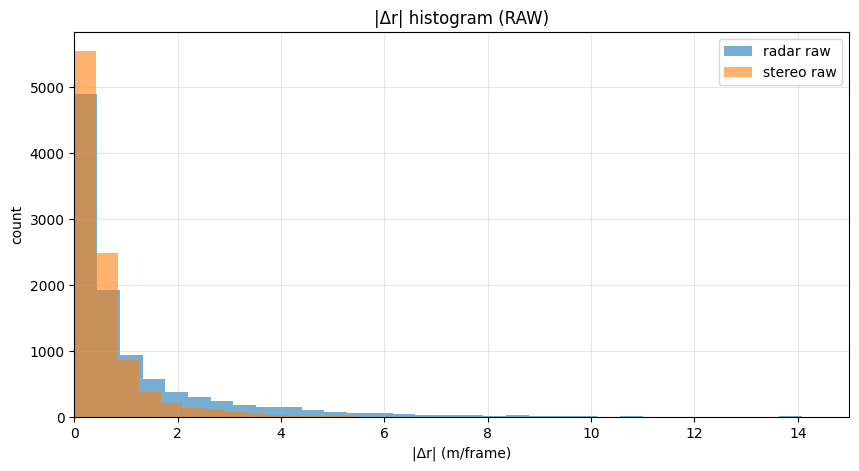


FILTERED data에 대한 수치화


,radar_mean,radar_median,stereo_mean,stereo_median
mad_abs_dr,0.357766,0.204705,0.147176,0.079426
p95_abs_dr,2.107529,1.547357,1.001335,0.567943
spike_rate_dd,0.054394,0.000000,0.008689,0.000000
trend_resid_mad,2.167065,0.927374,1.073630,0.365716
mad_dd,0.149886,0.057204,0.033634,0.014637
p95_abs_dd,0.977467,0.577040,0.271961,0.122757
n,37.514184,19.000000,39.622568,22.000000


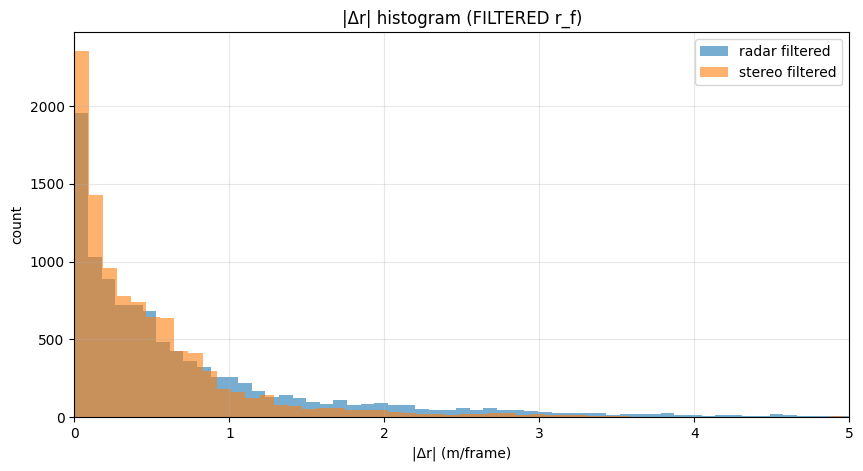


[Saved]
 RAW table: /content/drive/MyDrive/Colab Notebooks/Project1/outputs/stability_raw_table_like_slide.csv
 FILTERED table: /content/drive/MyDrive/Colab Notebooks/Project1/outputs/stability_filtered_table_like_slide.csv
 RAW hist: /content/drive/MyDrive/Colab Notebooks/Project1/outputs/hist_abs_dr_raw_count.png
 FILTERED hist: /content/drive/MyDrive/Colab Notebooks/Project1/outputs/hist_abs_dr_filtered_count.png


In [ ]:
import re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

warnings.filterwarnings("ignore", category=RuntimeWarning)

# =========================
# 0) Robust helpers
# =========================
def _is_num(x):
    try:
        return np.isfinite(float(x))
    except Exception:
        return False

def _to_sec(x):
    x = float(x)
    # heuristic: ns/us/ms/sec
    if x > 1e14:      # ns
        return x * 1e-9
    elif x > 1e11:    # us
        return x * 1e-6
    elif x > 1e9:     # ms
        return x * 1e-3
    return x

def _find_col(df, prefer_list=None, regex_list=None):
    cols = list(df.columns)
    if prefer_list:
        for c in prefer_list:
            if c in df.columns:
                return c
    if regex_list:
        for rgx in regex_list:
            pat = re.compile(rgx, flags=re.IGNORECASE)
            hits = [c for c in cols if pat.search(c)]
            if hits:
                hits = sorted(hits, key=lambda s: (len(s), s))
                return hits[0]
    return None

def _mad(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    med = np.median(x)
    return np.median(np.abs(x - med))

def _ema_per_track(df, track_col, t_col, v_col, alpha=0.2):
    out = np.full(len(df), np.nan, dtype=np.float64)
    tmp = df[[track_col, t_col, v_col]].copy()
    tmp["_idx"] = np.arange(len(df))
    tmp = tmp.sort_values([track_col, t_col, "_idx"]).reset_index(drop=True)

    last = {}
    for _, row in tmp.iterrows():
        tid = row[track_col]
        idx = int(row["_idx"])
        v = row[v_col]
        if not _is_num(v) or float(v) <= 0:
            continue
        v = float(v)
        if tid not in last or not np.isfinite(last[tid]):
            last[tid] = v
        else:
            last[tid] = alpha * v + (1.0 - alpha) * last[tid]
        out[idx] = last[tid]
    return out

# =========================
# 1) Track-wise metrics (사진 표에 맞춰 추가: mad_dd, p95_abs_dd)
# =========================
def _track_metrics(t, r):
    """
    r(t)에서 트랙 단위 지표:
      - mad_abs_dr = MAD(|Δr|)
      - p95_abs_dr = P95(|Δr|)
      - spike_rate_dd: dd = r[t+1]-2r[t]+r[t-1], tau=max(1.0, 5*MAD(|dd|)), mean(|dd|>tau)
      - trend_resid_mad: linear trend 제거 후 residual MAD
      - mad_dd = MAD(|dd|)
      - p95_abs_dd = P95(|dd|)
      - n
    """
    t = np.asarray(t, dtype=np.float64)
    r = np.asarray(r, dtype=np.float64)
    good = np.isfinite(t) & np.isfinite(r) & (r > 0)
    t, r = t[good], r[good]
    n = int(r.size)
    if n < 5:
        return None

    dr = np.diff(r)
    abs_dr = np.abs(dr)
    mad_abs_dr = _mad(abs_dr)
    p95_abs_dr = np.percentile(abs_dr[np.isfinite(abs_dr)], 95) if abs_dr.size else np.nan

    dd = r[2:] - 2.0*r[1:-1] + r[:-2] if n >= 3 else np.array([], dtype=np.float64)
    abs_dd = np.abs(dd) if dd.size else np.array([], dtype=np.float64)
    mad_dd = _mad(abs_dd) if abs_dd.size else np.nan
    p95_abs_dd = np.percentile(abs_dd[np.isfinite(abs_dd)], 95) if abs_dd.size else np.nan

    if abs_dd.size:
        tau = max(1.0, 5.0 * _mad(abs_dd))
        spike_rate_dd = float(np.mean(abs_dd > tau))
    else:
        spike_rate_dd = np.nan

    if np.std(t) < 1e-12:
        resid = r - np.median(r)
    else:
        a, b = np.polyfit(t, r, 1)
        resid = r - (a*t + b)
    trend_resid_mad = _mad(resid)

    return {
        "mad_abs_dr": float(mad_abs_dr),
        "p95_abs_dr": float(p95_abs_dr),
        "spike_rate_dd": float(spike_rate_dd),
        "trend_resid_mad": float(trend_resid_mad),
        "mad_dd": float(mad_dd),
        "p95_abs_dd": float(p95_abs_dd),
        "n": n,
    }

def _collect_abs_dr_all(df, track_col, t_col, r_col):
    """전체 트랙의 |Δr|를 하나로 합쳐 histogram용으로 반환"""
    vals = []
    sub = df[[track_col, t_col, r_col]].copy()
    sub = sub.rename(columns={track_col:"track_id", t_col:"t", r_col:"r"})
    sub["r"] = pd.to_numeric(sub["r"], errors="coerce")
    sub = sub[np.isfinite(sub["t"]) & np.isfinite(sub["r"]) & (sub["r"] > 0)].copy()
    if len(sub) == 0:
        return np.array([], dtype=np.float64)

    sub = sub.sort_values(["track_id","t"])
    for tid, g in sub.groupby("track_id"):
        r = g["r"].to_numpy()
        if r.size < 2:
            continue
        dr = np.abs(np.diff(r))
        dr = dr[np.isfinite(dr)]
        if dr.size:
            vals.append(dr)
    if not vals:
        return np.array([], dtype=np.float64)
    return np.concatenate(vals)

def _build_track_table(df, track_col, t_col, stereo_col, radar_col, min_track_len=5):
    """센서별(track_id 단위) 지표 계산 후 레이더/스테레오 mean/median 테이블 생성"""
    metrics = ["mad_abs_dr","p95_abs_dr","spike_rate_dd","trend_resid_mad","mad_dd","p95_abs_dd","n"]

    def per_sensor(col):
        rows = []
        sub = df[[track_col, t_col, col]].copy()
        sub = sub.rename(columns={track_col:"track_id", col:"r"})
        sub["r"] = pd.to_numeric(sub["r"], errors="coerce")
        sub = sub[np.isfinite(sub[t_col]) & np.isfinite(sub["r"]) & (sub["r"] > 0)].copy()
        sub = sub.sort_values(["track_id", t_col])
        for tid, g in sub.groupby("track_id"):
            t = g[t_col].to_numpy()
            r = g["r"].to_numpy()
            if r.size < min_track_len:
                continue
            met = _track_metrics(t, r)
            if met is None:
                continue
            rows.append(met)
        return pd.DataFrame(rows)

    radar_df  = per_sensor(radar_col)
    stereo_df = per_sensor(stereo_col)

    # mean/median 집계
    out = pd.DataFrame(index=metrics, columns=["radar_mean","radar_median","stereo_mean","stereo_median"], dtype=float)
    for m in metrics:
        out.loc[m, "radar_mean"]   = float(np.nanmean(radar_df[m].to_numpy()))  if len(radar_df)  else np.nan
        out.loc[m, "radar_median"] = float(np.nanmedian(radar_df[m].to_numpy())) if len(radar_df) else np.nan
        out.loc[m, "stereo_mean"]  = float(np.nanmean(stereo_df[m].to_numpy())) if len(stereo_df) else np.nan
        out.loc[m, "stereo_median"]= float(np.nanmedian(stereo_df[m].to_numpy())) if len(stereo_df) else np.nan

    return out, radar_df, stereo_df

def _auto_xlim(vals, cap):
    vals = np.asarray(vals, dtype=np.float64)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return cap
    return float(min(cap, max(1.0, np.percentile(vals, 99.5))))

# =========================
# 2) Load CSV & auto-map columns
# =========================
OUT_DIR = globals().get("OUT_DIR", None)
if OUT_DIR is None:
    PROJECT_DIR = globals().get("PROJECT_DIR", Path("/content/drive/MyDrive/Colab Notebooks/Project1"))
    OUT_DIR = Path(PROJECT_DIR) / "outputs"
OUT_DIR = Path(OUT_DIR)
csv_path = OUT_DIR / "track_timeseries.csv"
assert csv_path.exists(), f"track_timeseries.csv not found: {csv_path}"

df = pd.read_csv(csv_path)

track_col = _find_col(df, prefer_list=["track_id","_track_id","tid","id"], regex_list=[r"track.*id", r"tid$"])
time_col  = _find_col(df, prefer_list=["t_sec","t","time","timestamp","t_stereo"], regex_list=[r"t_?sec", r"time", r"stamp", r"t_stereo"])
assert track_col is not None and time_col is not None, f"track/time col mapping failed: {list(df.columns)}"

# raw cols
stereo_raw_col = _find_col(df,
    prefer_list=["stereo_dist_m","stereo_raw","stereo_dist_raw","stereo_dist"],
    regex_list=[r"stereo.*dist.*_m$", r"stereo.*raw", r"stereo.*dist"]
)
radar_raw_col  = _find_col(df,
    prefer_list=["radar_dist_m","radar_raw","radar_dist_raw","radar_dist"],
    regex_list=[r"radar.*dist.*_m$", r"radar.*raw", r"radar.*dist"]
)

# filtered cols
stereo_f_col = _find_col(df,
    prefer_list=["stereo_dist_f","stereo_f","stereo_dist_filtered","stereo_dist_ema"],
    regex_list=[r"stereo.*dist.*_f$", r"stereo.*filtered", r"stereo.*ema"]
)
radar_f_col  = _find_col(df,
    prefer_list=["radar_dist_f","radar_f","radar_dist_filtered","radar_dist_ema"],
    regex_list=[r"radar.*dist.*_f$", r"radar.*filtered", r"radar.*ema"]
)

assert stereo_raw_col is not None and radar_raw_col is not None, \
    f"raw distance columns not found. cols={list(df.columns)}"

df["_tsec"] = df[time_col].apply(lambda x: _to_sec(x) if _is_num(x) else np.nan).to_numpy()

df["_stereo_raw"] = pd.to_numeric(df[stereo_raw_col], errors="coerce")
df["_radar_raw"]  = pd.to_numeric(df[radar_raw_col],  errors="coerce")

EMA_ALPHA = 0.2
if stereo_f_col is not None:
    df["_stereo_f"] = pd.to_numeric(df[stereo_f_col], errors="coerce")
else:
    df["_stereo_f"] = _ema_per_track(df, track_col, "_tsec", "_stereo_raw", alpha=EMA_ALPHA)

if radar_f_col is not None:
    df["_radar_f"] = pd.to_numeric(df[radar_f_col], errors="coerce")
else:
    df["_radar_f"] = _ema_per_track(df, track_col, "_tsec", "_radar_raw", alpha=EMA_ALPHA)

print("[mapped columns]")
print(" track:", track_col, " time:", time_col, "-> _tsec")
print(" stereo_raw:", stereo_raw_col, " radar_raw:", radar_raw_col)
print(" stereo_f:", stereo_f_col, "(None이면 EMA)  radar_f:", radar_f_col, "(None이면 EMA)")
print(" EMA_ALPHA:", EMA_ALPHA)

# =========================
# 3) RAW: table + histogram
# =========================
raw_table, raw_radar_tracks, raw_stereo_tracks = _build_track_table(
    df, track_col, "_tsec", "_stereo_raw", "_radar_raw", min_track_len=5
)

print("\nROW data에 대한 수치화")
display(raw_table.style.format("{:.6f}"))

dr_radar_raw  = _collect_abs_dr_all(df, track_col, "_tsec", "_radar_raw")
dr_stereo_raw = _collect_abs_dr_all(df, track_col, "_tsec", "_stereo_raw")

plt.figure(figsize=(10,5))
plt.title("|Δr| histogram (RAW)")
plt.hist(dr_radar_raw,  bins=120, alpha=0.6, label="radar raw")
plt.hist(dr_stereo_raw, bins=120, alpha=0.6, label="stereo raw")
plt.xlabel("|Δr| (m/frame)")
plt.ylabel("count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, _auto_xlim(np.concatenate([dr_radar_raw, dr_stereo_raw]) if dr_radar_raw.size+dr_stereo_raw.size>0 else np.array([1.0]), cap=80.0))
raw_hist_path = OUT_DIR / "hist_abs_dr_raw_count.png"
plt.savefig(raw_hist_path, dpi=150, bbox_inches="tight")
plt.show()

# =========================
# 4) FILTERED: table + histogram
# =========================
f_table, f_radar_tracks, f_stereo_tracks = _build_track_table(
    df, track_col, "_tsec", "_stereo_f", "_radar_f", min_track_len=5
)

print("\nFILTERED data에 대한 수치화")
display(f_table.style.format("{:.6f}"))

dr_radar_f  = _collect_abs_dr_all(df, track_col, "_tsec", "_radar_f")
dr_stereo_f = _collect_abs_dr_all(df, track_col, "_tsec", "_stereo_f")

plt.figure(figsize=(10,5))
plt.title("|Δr| histogram (FILTERED r_f)")
plt.hist(dr_radar_f,  bins=120, alpha=0.6, label="radar filtered")
plt.hist(dr_stereo_f, bins=120, alpha=0.6, label="stereo filtered")
plt.xlabel("|Δr| (m/frame)")
plt.ylabel("count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, _auto_xlim(np.concatenate([dr_radar_f, dr_stereo_f]) if dr_radar_f.size+dr_stereo_f.size>0 else np.array([1.0]), cap=5.0))
f_hist_path = OUT_DIR / "hist_abs_dr_filtered_count.png"
plt.savefig(f_hist_path, dpi=150, bbox_inches="tight")
plt.show()

# =========================
# 5) Save tables
# =========================
raw_csv = OUT_DIR / "stability_raw_table_like_slide.csv"
f_csv   = OUT_DIR / "stability_filtered_table_like_slide.csv"
raw_table.to_csv(raw_csv)
f_table.to_csv(f_csv)

print("\n[Saved]")
print(" RAW table:", raw_csv)
print(" FILTERED table:", f_csv)
print(" RAW hist:", raw_hist_path)
print(" FILTERED hist:", f_hist_path)